In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from numerapi import NumerAPI
import pandas as pd
import numpy as np
import os
import pyarrow as pa
from tqdm.notebook import tqdm
from pyarrow.parquet import ParquetFile
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
class Regressor(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.net = nn.Sequential(
            nn.Linear(1050, 500),
            nn.BatchNorm1d(500),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(500, 250),
            nn.BatchNorm1d(250),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(250,125),
            nn.BatchNorm1d(125),
            nn.ReLU(),
            nn.Dropout(0.2),
            
            nn.Linear(125, 1),  
        )

    def forward(self, x):
        x = self.net(x)
        return x

In [3]:
def create_ft_and_trg_tensors(batch, target=True):
    df = batch.to_pandas()
    fc = [i for i in df.columns if 'feature' in i]
    ft = torch.tensor(df[fc].values, dtype=torch.float32)
    if target:
        tl = df['target'].values
        tt = torch.tensor(tl, dtype=torch.float32)
        return ft, tt
    else:

        return list(df.index), ft

In [4]:
tr_data_path = os.path.join('data', 'numerai_training_data.parquet')
val_dat_path = os.path.join('data', 'numerai_validation_data.parquet')
pf = ParquetFile(tr_data_path)
val_pf = ParquetFile(val_dat_path)

In [5]:
model = Regressor().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0002) 
criterion = nn.MSELoss()

In [6]:
BATCH_SIZE = 1024
b_sizes = []
for i in pf.iter_batches(batch_size=2**17):
    b_sizes.append(i.num_rows)

num_rows = sum(b_sizes)
num_rows

2412105

In [7]:

EPOCHS = 1

t_losses = []
sample_losses = []
for k in tqdm(range(EPOCHS)):
    epoch_loss = 0
    for i, batch in tqdm(enumerate(pf.iter_batches(batch_size=BATCH_SIZE)), total=num_rows/BATCH_SIZE, leave=False):
        features, target = create_ft_and_trg_tensors(batch)
        features, target = features.to(DEVICE), target.to(DEVICE)
        optimizer.zero_grad()
        pred = model(features)
        loss = criterion(pred.squeeze(), target)
        epoch_loss += loss.item()
        sample_losses.append(loss.item())
        loss.backward()
        optimizer.step()
    t_losses.append(epoch_loss)


    

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2355.5712890625 [00:00<?, ?it/s]

In [8]:
print(t_losses)

[159.28731064870954]


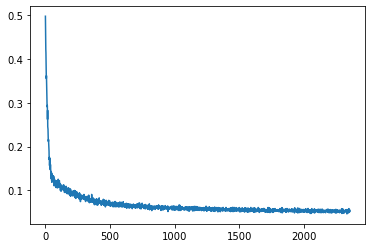

In [9]:
import matplotlib.pyplot as plt
plt.plot(sample_losses)

In [10]:
model.eval()
with torch.no_grad():
    val_losses = []
    for i, batch in tqdm(enumerate(val_pf.iter_batches(batch_size=BATCH_SIZE)), leave=False):
        features, target = create_ft_and_trg_tensors(batch)
        features, target = features.to(DEVICE), target.to(DEVICE)
        pred = model(features)
        loss = criterion(pred.squeeze(), target)
        val_losses.append(loss.item())

0it [00:00, ?it/s]

In [11]:
tournament_data_path = os.path.join('data', 'numerai_tournament_data.parquet')
tpf = ParquetFile(tournament_data_path)

model.eval()
with torch.no_grad():
    predictions = []
    idsl = []
    for i, batch in tqdm(enumerate(tpf.iter_batches(batch_size=BATCH_SIZE))):
        ids, features = create_ft_and_trg_tensors(batch, target=False)
        features = features.to(DEVICE)
        pred = model(features)
        predictions.append([i for i in pred.squeeze().cpu().detach().numpy()])
        idsl.append([i for i in ids])

0it [00:00, ?it/s]

In [12]:
1380*BATCH_SIZE

1413120

In [13]:
preds = [p for sublist in predictions for p in sublist]

In [14]:
len(preds)

1412824

In [19]:
idsl = [i for sublist in idsl for i in sublist]

In [20]:
submission = []
for i in range(len(preds)):
    submission.append((idsl[i], preds[i]))
submission

[('n000101811a8a843', 0.48650464),
 ('n001e1318d5072ac', 0.50117785),
 ('n002a9c5ab785cbb', 0.4924989),
 ('n002ccf6d0e8c5ad', 0.50553197),
 ('n0051ab821295c29', 0.48870942),
 ('n008361ac9e9bd47', 0.49734017),
 ('n009e95486e1d64c', 0.50015026),
 ('n00b093a02b84295', 0.5283568),
 ('n00b84e81c983a0a', 0.4760355),
 ('n00d453202699c32', 0.49460587),
 ('n0111569664442c0', 0.50609356),
 ('n011918793bbc8bd', 0.49865097),
 ('n011f5fa6223f1b6', 0.4903425),
 ('n0133bb17791bf04', 0.46297875),
 ('n0133d8b7b8cfcb3', 0.48894113),
 ('n0134685c90beda8', 0.47563446),
 ('n01697e879bea381', 0.49475384),
 ('n018c3bf5e901e8d', 0.5144064),
 ('n018e95bc0644093', 0.48879588),
 ('n019acfd80b8b98f', 0.5142408),
 ('n01a3ca7e6ab3f05', 0.5082152),
 ('n01b2cf0d940d2d9', 0.49356216),
 ('n01b768baba146be', 0.44966087),
 ('n01bad6ff1b4a76b', 0.49522287),
 ('n01c78de6b659716', 0.4919143),
 ('n01d407bebbed710', 0.4860612),
 ('n01e9c3c60bbdda3', 0.467463),
 ('n01f4089c878a426', 0.48574272),
 ('n020bcb1e96903be', 0.5087758

In [24]:
sub = pd.DataFrame(submission)

In [26]:
sub.to_csv('submission.csv', index=False)

In [ ]:
list(x.to_pandas().index)

['n000101811a8a843', 'n001e1318d5072ac']

In [27]:
len(set(idsl))

1412824

In [28]:
len(idsl)

1412824

In [29]:
idsl

['n000101811a8a843',
 'n001e1318d5072ac',
 'n002a9c5ab785cbb',
 'n002ccf6d0e8c5ad',
 'n0051ab821295c29',
 'n008361ac9e9bd47',
 'n009e95486e1d64c',
 'n00b093a02b84295',
 'n00b84e81c983a0a',
 'n00d453202699c32',
 'n0111569664442c0',
 'n011918793bbc8bd',
 'n011f5fa6223f1b6',
 'n0133bb17791bf04',
 'n0133d8b7b8cfcb3',
 'n0134685c90beda8',
 'n01697e879bea381',
 'n018c3bf5e901e8d',
 'n018e95bc0644093',
 'n019acfd80b8b98f',
 'n01a3ca7e6ab3f05',
 'n01b2cf0d940d2d9',
 'n01b768baba146be',
 'n01bad6ff1b4a76b',
 'n01c78de6b659716',
 'n01d407bebbed710',
 'n01e9c3c60bbdda3',
 'n01f4089c878a426',
 'n020bcb1e96903be',
 'n0224405daa13a2e',
 'n0248b4a05ecc990',
 'n024acfbc0033b94',
 'n02668fc1bd78df8',
 'n02688464062f2e6',
 'n027444e9269b270',
 'n029c34c6e50d680',
 'n02bdd96e5bc31f2',
 'n02c58f678652178',
 'n02dc95d53722be0',
 'n02ed7a31bf92cf3',
 'n02ee72ab561de40',
 'n02f81b8209248d4',
 'n02fbc66384f6c98',
 'n02fbfec8f3d82de',
 'n03444ba6e223a16',
 'n03482b39c9b798a',
 'n034969d99ac7365',
 'n034a69bd41